# JSBSim Turbine Engine Model

```xml
<turbine_engine name="{string}">
 <milthrust unit="{LBS | N}"> {number} </milthrust>
 <maxthrust unit="{LBS | N}"> {number} </maxthrust>
 <bypassratio> {number} </bypassratio>
 <bleed> {number} </bleed>
 <tsfc> {number} </tsfc>
 <atsfc> {number} </atsfc>
 <idlen1> {number} </idlen1>
 <idlen2> {number} </idlen2>
 <n1spinup> {number} </n1spinup>
 <n2spinup> {number} </n2spinup>
 <maxn1> {number} </maxn1>
 <maxn2> {number} </maxn2>
 <augmented> {0 | 1} </augmented>
 <augmethod> {0 | 1 | 2} </augmethod>
 <injected> {0 | 1} </injected>
 <injection-time> {number} </injection-time>
</turbine_engine>
```

Definition of the turbine engine configuration file parameters:
* milthrust   - Maximum thrust, static, at sea level.
* maxthrust   - Afterburning thrust, static, at sea level.
* bypassratio - Ratio of bypass air flow to core air flow.
* bleed       - Thrust reduction factor due to losses (0.0 to 1.0).
* tsfc        - Thrust-specific fuel consumption at cruise, lbm/hr/lbf
* atsfc       - Afterburning TSFC, lbm/hr/lbf
* idlen1      - Fan rotor rpm (% of max) at idle
* idlen2      - Core rotor rpm (% of max) at idle
* n1spinup    - Fan rotor rpm starter acceleration (default 1.0)
* n2spinup    - Core rotor rpm starter acceleration (default 3.0)
* maxn1       - Fan rotor rpm (% of max) at full throttle 
* maxn2       - Core rotor rpm (% of max) at full throttle
* augmented
  * 0 = afterburner not installed
  * 1 = afterburner installed
* augmethod
  * 0 = afterburner activated by property /engines/engine[n]/augmentation
  * 1 = afterburner activated by pushing throttle above 99% position
  * 2 = throttle range is expanded in the FCS, and values above 1.0 are afterburner range
* injected
  * 0 = Water injection not installed
  * 1 = Water injection installed
* injection-time - Time, in seconds, of water injection duration 
* InjN1increment - % increase in N1 when injection is taking place
* InjN2increment - % increase in N2 when injection is taking place
NOTES:
    Bypass ratio is used only to estimate engine acceleration time.  The
    effect of bypass ratio on engine efficiency is already included in
    the TSFC value.  Feel free to set this parameter (even for turbojets) to
    whatever value gives a desired spool-up rate. Default value is 0.
    The bleed factor is multiplied by thrust to give a resulting thrust
    after losses.  This can represent losses due to bleed, or any other cause.
    Default value is 0.  A common value would be 0.04.
    Nozzle position, for variable area exhaust nozzles, is provided for users
    needing to drive a nozzle gauge or animate a virtual nozzle.
    This model can only be used with the "direct" thruster.  See the file:
    /engine/direct.xml
    

* **Reference**: http://jsbsim.sourceforge.net/JSBSim/classJSBSim_1_1FGTurbine.html


## FTTurbine Source Code
```c++
double FGTurbine::Run()
{
  double idlethrust, milthrust, thrust;

  idlethrust = MilThrust * IdleThrustLookup->GetValue();
  milthrust = (MilThrust - idlethrust) * MilThrustLookup->GetValue();

  Running = true;
  Starter = false;

  N1_factor = MaxN1 - IdleN1;
  N2_factor = MaxN2 - IdleN2;
  if ((Injected == 1) && Injection && (InjWaterNorm > 0)) {
    N1_factor += InjN1increment;
    N2_factor += InjN2increment;
  }
  N2 = Seek(&N2, IdleN2 + ThrottlePos * N2_factor,
            N2SpoolUp->GetValue(), N2SpoolDown->GetValue());
  N1 = Seek(&N1, IdleN1 + ThrottlePos * N1_factor,
            N1SpoolUp->GetValue(), N1SpoolDown->GetValue());
  N2norm = (N2 - IdleN2) / N2_factor;
  thrust = idlethrust + (milthrust * N2norm * N2norm);
  EGT_degC = in.TAT_c + 363.1 + ThrottlePos * 357.1;
  OilPressure_psi = N2 * 0.62;
  OilTemp_degK = Seek(&OilTemp_degK, 366.0, 1.2, 0.1);

  if (!Augmentation) {
    correctedTSFC = TSFC->GetValue();
    FuelFlow_pph = Seek(&FuelFlow_pph, thrust * correctedTSFC, 1000.0, 10000.0);
    if (FuelFlow_pph < IdleFF) FuelFlow_pph = IdleFF;
    NozzlePosition = Seek(&NozzlePosition, 1.0 - N2norm, 0.8, 0.8);
    thrust = thrust * (1.0 - BleedDemand);
    EPR = 1.0 + thrust/MilThrust;
  }

  if (AugMethod == 1) {
    if ((ThrottlePos > 0.99) && (N2 > 97.0)) {Augmentation = true;}
    else {Augmentation = false;}
  }

  if ((Augmented == 1) && Augmentation && (AugMethod < 2)) {
    thrust = MaxThrustLookup->GetValue() * MaxThrust;
    FuelFlow_pph = Seek(&FuelFlow_pph, thrust * ATSFC->GetValue(), 5000.0, 10000.0);
    NozzlePosition = Seek(&NozzlePosition, 1.0, 0.8, 0.8);
  }

  if (AugMethod == 2) {
    if (AugmentCmd > 0.0) {
      Augmentation = true;
      double tdiff = (MaxThrust * MaxThrustLookup->GetValue()) - thrust;
      thrust += (tdiff * AugmentCmd);
      FuelFlow_pph = Seek(&FuelFlow_pph, thrust * ATSFC->GetValue(), 5000.0, 10000.0);
      NozzlePosition = Seek(&NozzlePosition, 1.0, 0.8, 0.8);
    } else {
      Augmentation = false;
    }
  }

  if ((Injected == 1) && Injection && (InjWaterNorm > 0.0)) {
    InjectionTimer += in.TotalDeltaT;
    if (InjectionTimer < InjectionTime) {
       thrust = thrust * InjectionLookup->GetValue();
       InjWaterNorm = 1.0 - (InjectionTimer/InjectionTime);
    } else {
       Injection = false;
       InjWaterNorm = 0.0;
    }
  }

  if (Cutoff) phase = tpOff;
  if (Starved) phase = tpOff;

  return thrust;
}
```

In [2]:
import jsbsim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from logger import Logger
import time

fdm = jsbsim.FGFDMExec('.', None)
fdm.set_engine_path('engine')
fdm.set_output_directive('data_output/flightgear.xml')
success = fdm.load_script('thrust_test.xml')
if not success:
    raise Exception('load failed, see terminal')

log = Logger()

fdm.run_ic()
#fdm.set_property_value('atmosphere/gust-north-gps',  10.0)
#fdm.set_property_value('atmosphere/turbulence/milspec/severity',  1.0)
realtime = True
nice = True
sleep_nseconds = 1000
initial_seconds = time.time()
frame_duration = fdm.get_delta_t()
result = fdm.run()

while result:
    t = fdm.get_sim_time()
    if realtime:
        current_seconds = time.time()
        actual_elapsed_time = current_seconds - initial_seconds
        sim_lag_time = actual_elapsed_time - fdm.get_sim_time()

        for _ in range(int(sim_lag_time / frame_duration)):
            result = fdm.run()
            current_seconds = time.time()
    else:
        result = fdm.run()
        if nice:
            time.sleep(sleep_nseconds / 1000000.0)
            
    log.new_frame(
        t, fdm.get_property_catalog(''))

log = log.to_pandas()
ft2m = 0.3048
m2ft = 1/ft2m

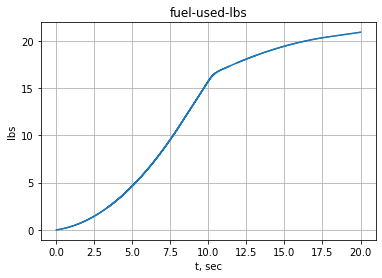

In [3]:
plt.figure()
log['propulsion/engine/fuel-used-lbs'].plot()
plt.title('fuel-used-lbs')
plt.ylabel('lbs')
plt.grid()

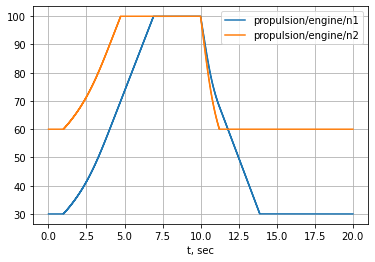

In [4]:
plt.figure()
log['propulsion/engine/n1'].plot()
log['propulsion/engine/n2'].plot()
plt.legend()
plt.grid()

Text(0.5, 1.0, 'thrust')

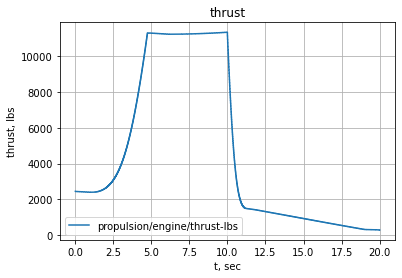

In [5]:
plt.figure()
log['propulsion/engine/thrust-lbs'].plot()
plt.legend()
plt.grid()
plt.ylabel('thrust, lbs')
plt.title('thrust')

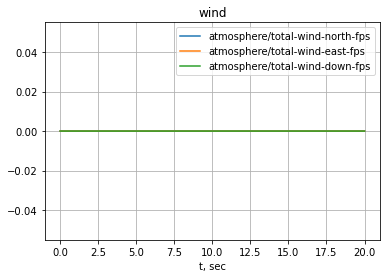

In [6]:
plt.figure()
plt.title('wind')
log['atmosphere/total-wind-north-fps'].plot()
log['atmosphere/total-wind-east-fps'].plot()
log['atmosphere/total-wind-down-fps'].plot()
plt.legend()
plt.grid()

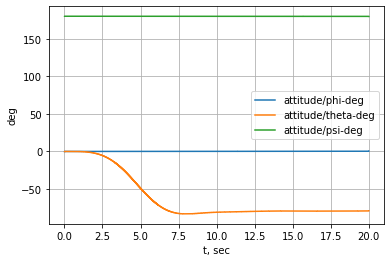

In [7]:
plt.figure()
log['attitude/phi-deg'].plot()
log['attitude/theta-deg'].plot()
log['attitude/psi-deg'].plot()
plt.ylabel('deg')
plt.legend()
plt.grid()

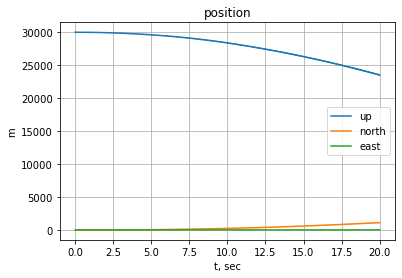

In [8]:
plt.figure()
log['position/h-agl-ft'].plot(label='up')
(log['position/distance-from-start-lat-mt']*m2ft).plot(label='north')
(log['position/distance-from-start-lon-mt']*m2ft).plot(label='east')
plt.ylabel('m')
plt.legend()
plt.grid()
plt.title('position');

In [9]:
fdm.get_property_catalog('')

{'inertial/sea-level-radius_ft': 20896072.880188853,
 'simulation/gravity-model': 1.0,
 'simulation/integrator/rate/rotational': 1.0,
 'simulation/integrator/rate/translational': 3.0,
 'simulation/integrator/position/rotational': 1.0,
 'simulation/integrator/position/translational': 4.0,
 'simulation/write-state-file': 0.0,
 'simulation/channel-dt': 0.01,
 'simulation/gravitational-torque': 0.0,
 'simulation/force-output': 0.0,
 'simulation/do_simple_trim': 0.0,
 'simulation/reset': 0.0,
 'simulation/disperse': 0.0,
 'simulation/randomseed': 0.0,
 'simulation/terminate': 0.0,
 'simulation/pause': -970981376.0,
 'simulation/sim-time-sec': 20.01000000000033,
 'simulation/dt': 0.01,
 'simulation/jsbsim-debug': 1.0,
 'simulation/frame': 2001.0,
 'simulation/trim-completed': 0.0,
 'simulation/output/log_rate_hz': 50.0,
 'simulation/output/enabled': 1.0,
 'velocities/h-dot-fps': -628.4335013214961,
 'velocities/v-north-fps': -117.06968356043085,
 'velocities/v-east-fps': 0.4645937245449154,


<AxesSubplot:xlabel='t, sec'>

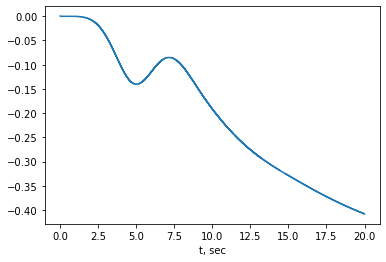

In [13]:
log['aero/coefficient/Clr'].plot()

In [14]:
fdm.get_property_catalog('')

{'inertial/sea-level-radius_ft': 20896072.880188853,
 'simulation/gravity-model': 1.0,
 'simulation/integrator/rate/rotational': 1.0,
 'simulation/integrator/rate/translational': 3.0,
 'simulation/integrator/position/rotational': 1.0,
 'simulation/integrator/position/translational': 4.0,
 'simulation/write-state-file': 0.0,
 'simulation/channel-dt': 0.01,
 'simulation/gravitational-torque': 0.0,
 'simulation/force-output': 0.0,
 'simulation/do_simple_trim': 0.0,
 'simulation/reset': 0.0,
 'simulation/disperse': 0.0,
 'simulation/randomseed': 0.0,
 'simulation/terminate': 0.0,
 'simulation/pause': -970981376.0,
 'simulation/sim-time-sec': 20.01000000000033,
 'simulation/dt': 0.01,
 'simulation/jsbsim-debug': 1.0,
 'simulation/frame': 2001.0,
 'simulation/trim-completed': 0.0,
 'simulation/output/log_rate_hz': 50.0,
 'simulation/output/enabled': 1.0,
 'velocities/h-dot-fps': -628.4335013214961,
 'velocities/v-north-fps': -117.06968356043085,
 'velocities/v-east-fps': 0.4645937245449154,
